In [9]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import seaborn as sns

# import flox.learn.prototype as flox_learn

from flox.learn import federated_fit
from flox.strategies import FedSGD

from concurrent.futures import Future, ThreadPoolExecutor
from functools import partial
from pathlib import Path
from torch import nn
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

from flox.flock import Flock
from flox.flock.node import FlockNodeID, FlockNodeKind

sns.set_style("darkgrid")

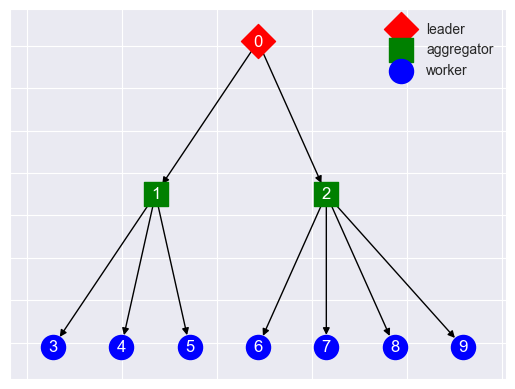

In [10]:
path = Path("examples/flock_files/3-tier.yaml")
flock = Flock.from_yaml(path)
flock.draw()
plt.legend(frameon=False)
plt.savefig(
    Path("out/plots") /
    path.parts[-1].replace("yaml", "pdf")
)
plt.show()

# Hierarchical Aggregation
Below, we provide a simple surrogate implementation of *Federated Learning* (via *Federated Averaging*). Rather than averaging model weights learned via deep learning, each worker device in the above `Flock` generates a random number of integers as their private, local data. The aggregators are then responsible for performing a *weighted average* across the all their children (note: this may also include other aggregators). 

The below implementation is heavily based on Yadu's implementation of the hierarchical execution framework provided [here](https://github.com/yadudoc/FLoX-experimental/blob/main/test.ipynb).

In [11]:
POOL = ThreadPoolExecutor(max_workers=1)


def local_fit_fn(idx) -> dict[str, float]:
    num_data = np.random.randint(10, 100)
    data = np.random.randint(1, 1000, size=num_data)
    avg = np.mean(data)
    print(f"[WORKER={idx}]  local_fit()  ::  {num_data=}  ::  {avg=:0.3f}")
    return {
        "num_data": num_data,
        "avg": avg
    }


def aggr_fn(content: list[dict[str, float]]) -> dict[str, float]:
    weights, averages = [], []
    for d in content:
        weights.append(d["num_data"])
        averages.append(d["avg"])
    avg = np.average(averages, weights=weights)
    return {
        "num_data": sum(weights),
        "avg": avg
    }


def set_parent_future(parent_future, child_future):
    assert child_future.done()
    if child_future.exception():
        parent_future.set_exception(child_future.exception())
    else:
        result = child_future.result()
        try:
            parent_future.set_result(result)
        except Exception:
            logging.exception("FAILED")
        return result


def aggr_callback(children_futures, future_of_self, idx_of_self, child_fut_to_resolve):
    if all([f.done() for f in children_futures]):
        child_results = [f.result() for f in children_futures]

        weights = []
        averages = []
        for res in child_results:
            weights.append(res["num_data"])
            averages.append(res["avg"])

        future = POOL.submit(aggr_fn, child_results)
        custom_callback = partial(set_parent_future, future_of_self)
        result = future.add_done_callback(custom_callback)
        if result is not None:
            num_data = result["num_data"]
            avg = result["avg"]
            print(f"[AGGR={idx_of_self}]  aggr_fn()  ::  {num_data=}  ::  {avg=:0.3f}!")


def traverse(flock: Flock, idx: FlockNodeID):
    if flock.topo.nodes[idx]["kind"] is FlockNodeKind.WORKER:
        future = POOL.submit(local_fit_fn, idx)
        return future
    else:
        children_futures = [traverse(flock, child) for child in flock.topo.successors(idx)]
        # print(f"[AGGR={idx}] children_futures -> {children_futures}")
        aggr_future = Future()
        callback = partial(aggr_callback, children_futures, aggr_future, idx)
        for child_fut in children_futures:
            child_fut.add_done_callback(callback)

        # print(aggr_future)
        return aggr_future


def sync_fed_fit(flock: Flock):
    root = flock.leader
    return traverse(flock, idx=root.idx)

## Does it work?
We can run the above code by simply running `sync_fed_fit(flock)` which then returns the `Future` for the leader node in the `Flock` (i.e., call `result()` to get the final output). As we can see, it does work (this can be confirmed by summing the values of `num_data` across all the workers and seeing that the sum matches what the leader reports).

This execution corresponds with a single (global) aggregation round.

In [12]:
np.random.seed(123)
fut = sync_fed_fit(flock)
print(f"\nLeader node's final result: {fut.result()}")

[WORKER=3]  local_fit()  ::  num_data=76  ::  avg=453.947
[WORKER=4]  local_fit()  ::  num_data=90  ::  avg=504.933
[WORKER=5]  local_fit()  ::  num_data=86  ::  avg=508.407
[WORKER=6]  local_fit()  ::  num_data=33  ::  avg=497.606
[WORKER=7]  local_fit()  ::  num_data=13  ::  avg=599.462
[WORKER=8]  local_fit()  ::  num_data=76  ::  avg=515.237
[WORKER=9]  local_fit()  ::  num_data=11  ::  avg=552.727

Leader node's final result: {'num_data': 385, 'avg': 501.6077922077922}


## Requirements

There are some requirements that need to be put in place in order for this execution model to work. 
- What is returned from `local_fit_fn()` and `aggr_fn()` must have the same structure.
    - This is because the `aggr_fn()` may be doing aggregation with the results from calls to `local_fit_fn()` and other calls to `aggr_fn()`. Keeping the structure of results the same for both functions will make this execution work.
- Aggregation rounds on one sub-tree of the Flock cannot started until the other subtrees have finished. In other words, the FL process cannot move onto the next global round until the entire tree has executed.

 

# Hierarchical FL Implementation
Using the framework presented above, we now run a prototype implementation of hierarchical FL with FLoX's interface based on the above framework.

In [13]:
from flox.utils.data.federate import randomly_federate_dataset

mnist = FashionMNIST(
    root=os.environ["TORCH_DATASETS"],
    download=False,
    train=True,
    transform=ToTensor(),
)
fed_data = randomly_federate_dataset(
    flock,
    mnist,
    shuffle=True,
    random_state=None,
)
fed_data

{3: <torch.utils.data.dataset.Subset at 0x7f7c1a8447c0>,
 4: <torch.utils.data.dataset.Subset at 0x7f7c1a8446d0>,
 5: <torch.utils.data.dataset.Subset at 0x7f7c1a845ba0>,
 6: <torch.utils.data.dataset.Subset at 0x7f7c1a845060>,
 7: <torch.utils.data.dataset.Subset at 0x7f7bf83d0160>,
 8: <torch.utils.data.dataset.Subset at 0x7f7bf83d1c30>,
 9: <torch.utils.data.dataset.Subset at 0x7f7bf83d1bd0>}

In [14]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

In [15]:
# train_history = flox_learn.federated_fit(flock, MyModule, fed_data, 5)
# train_history["time"] = pd.to_datetime(train_history["time"])
# train_history.head()

train_history = federated_fit(flock, MyModule, fed_data, 5, strategy=FedSGD())
train_history["time"] = pd.to_datetime(train_history["time"])
train_history.head()

federated_fit::sync: 100%|██████████| 5/5 [01:22<00:00, 16.57s/it]


,index,node/idx,node/kind,parent/idx,parent/kind,train/loss,epoch,time,round
0,0,3,FlockNodeKind.WORKER,1,FlockNodeKind.AGGREGATOR,2.281969,0,2023-08-23 15:56:20.924858,0
1,1,3,FlockNodeKind.WORKER,1,FlockNodeKind.AGGREGATOR,2.243916,1,2023-08-23 15:56:21.898040,0
2,2,4,FlockNodeKind.WORKER,1,FlockNodeKind.AGGREGATOR,2.283546,0,2023-08-23 15:56:22.864284,0
3,3,4,FlockNodeKind.WORKER,1,FlockNodeKind.AGGREGATOR,2.245829,1,2023-08-23 15:56:23.853548,0
4,4,5,FlockNodeKind.WORKER,1,FlockNodeKind.AGGREGATOR,2.283248,0,2023-08-23 15:56:25.110216,0


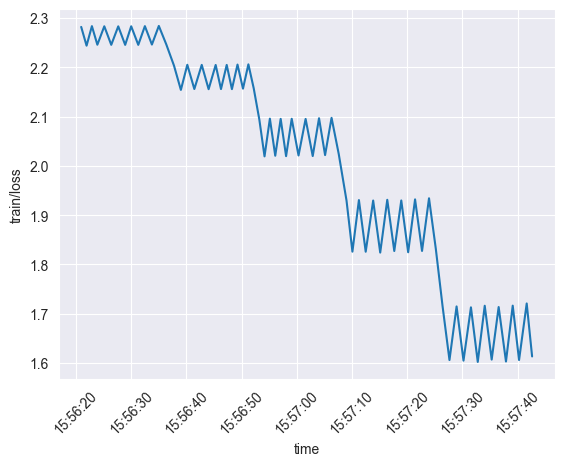

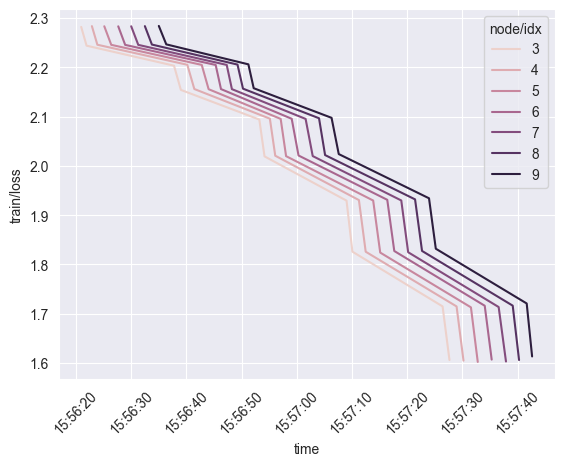

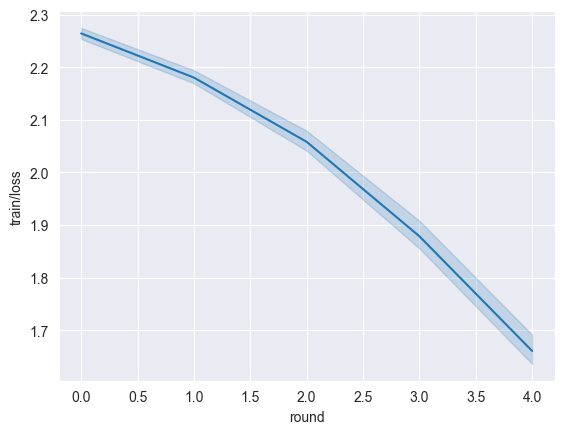

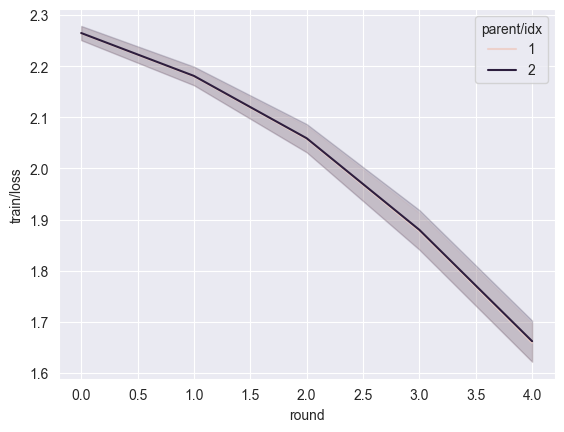

In [16]:
sns.lineplot(train_history, x="time", y="train/loss")
plt.xticks(rotation=45)
plt.show()

sns.lineplot(train_history, x="time", y="train/loss", hue="node/idx")
plt.xticks(rotation=45)
plt.show()

sns.lineplot(train_history, x="round", y="train/loss")
plt.show()

sns.lineplot(train_history, x="round", y="train/loss", hue="parent/idx")
plt.show()

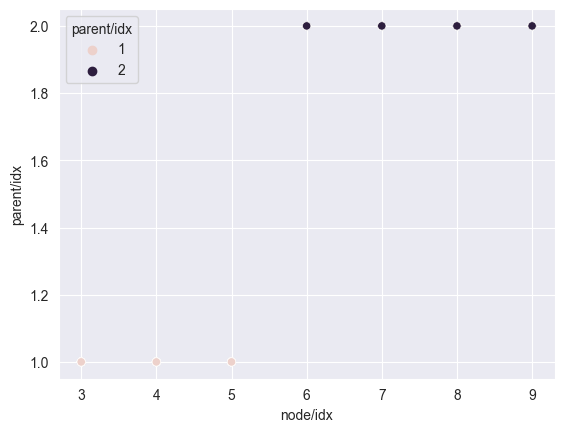

In [17]:
sns.scatterplot(train_history, x="node/idx", y="parent/idx", hue="parent/idx")
plt.show()